### 预测新图像

In [1]:
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image,ImageFont,ImageDraw

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 载入类别

In [2]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
idx_to_labels

{0: 'Angular',
 1: 'Rounded',
 2: 'Subangular',
 3: 'Subrounded',
 4: 'Very angular',
 5: 'Well rounded'}

### 导入训练好的模型

In [3]:
model = torch.load('checkpoint/Particle Figures_pytorch_C1.pth')
model = model.eval().to(device)

### 预处理

In [4]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入一张测试图像

In [5]:
from PIL import Image

In [6]:
img_path = 'test_img/test_1.jpg'
#img_path = 'test_img/test_2.jpg'
#img_path = 'test_img/test_3.jpg'

In [7]:
img_pil = Image.open(img_path)

In [8]:
np.array(img_pil).shape

(375, 500, 3)

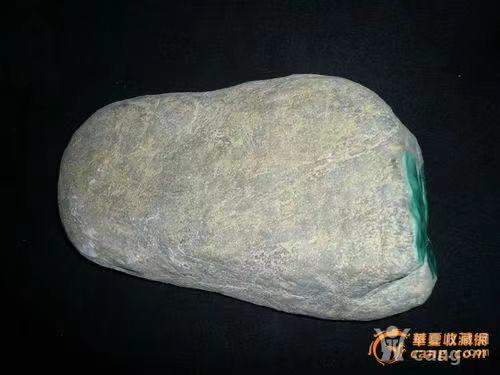

In [9]:
img_pil

### 预处理、前向预测

In [10]:
input_img = test_transform(img_pil) # 预处理

In [11]:
input_img.shape

torch.Size([3, 224, 224])

In [12]:
input_img = input_img.unsqueeze(0).to(device)

In [13]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [14]:
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img) 

In [15]:
pred_logits

tensor([[-2.2885, -2.0200,  0.2477, -0.7007, -2.1430, -2.6076]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [17]:
pred_softmax

tensor([[0.0460, 0.0602, 0.5817, 0.2253, 0.0533, 0.0335]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

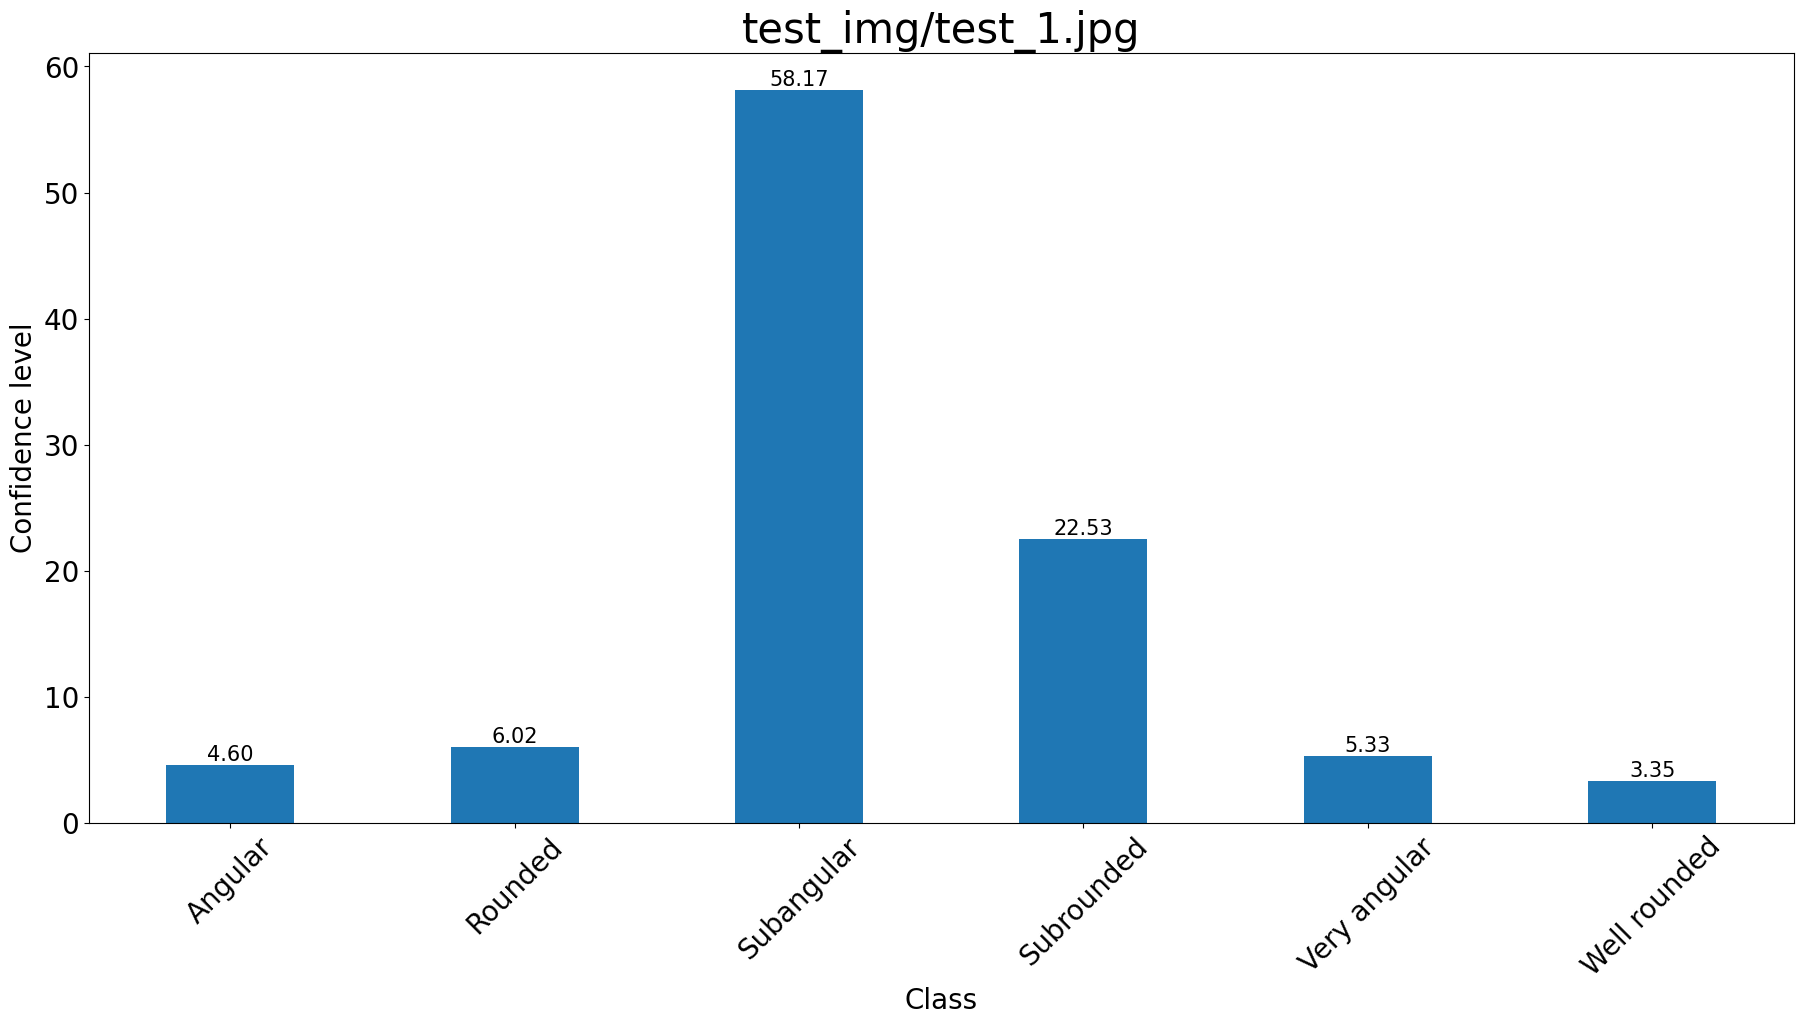

In [18]:
plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence level', fontsize=20)
plt.show()

### 置信度最大的前 n 个结果 分类结果写在图上

In [19]:
n = 3
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [20]:
pred_ids

array([2, 3, 1])

In [21]:
confs

array([0.581679  , 0.22531202, 0.06023251], dtype=float32)

In [22]:
draw = ImageDraw.Draw(img_pil)

In [23]:
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence) # 保留 4 位小数
    print(text)
    
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, fill=(255, 0, 0, 1))

Subangular      58.1679
Subrounded      22.5312
Rounded         6.0233


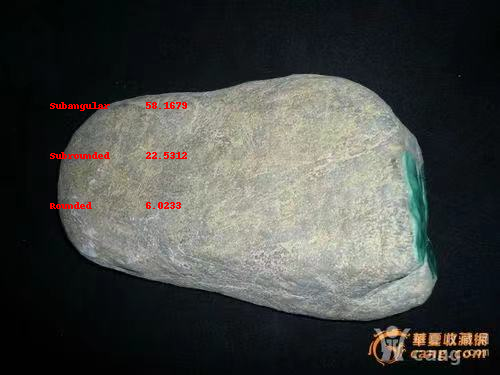

In [24]:
img_pil

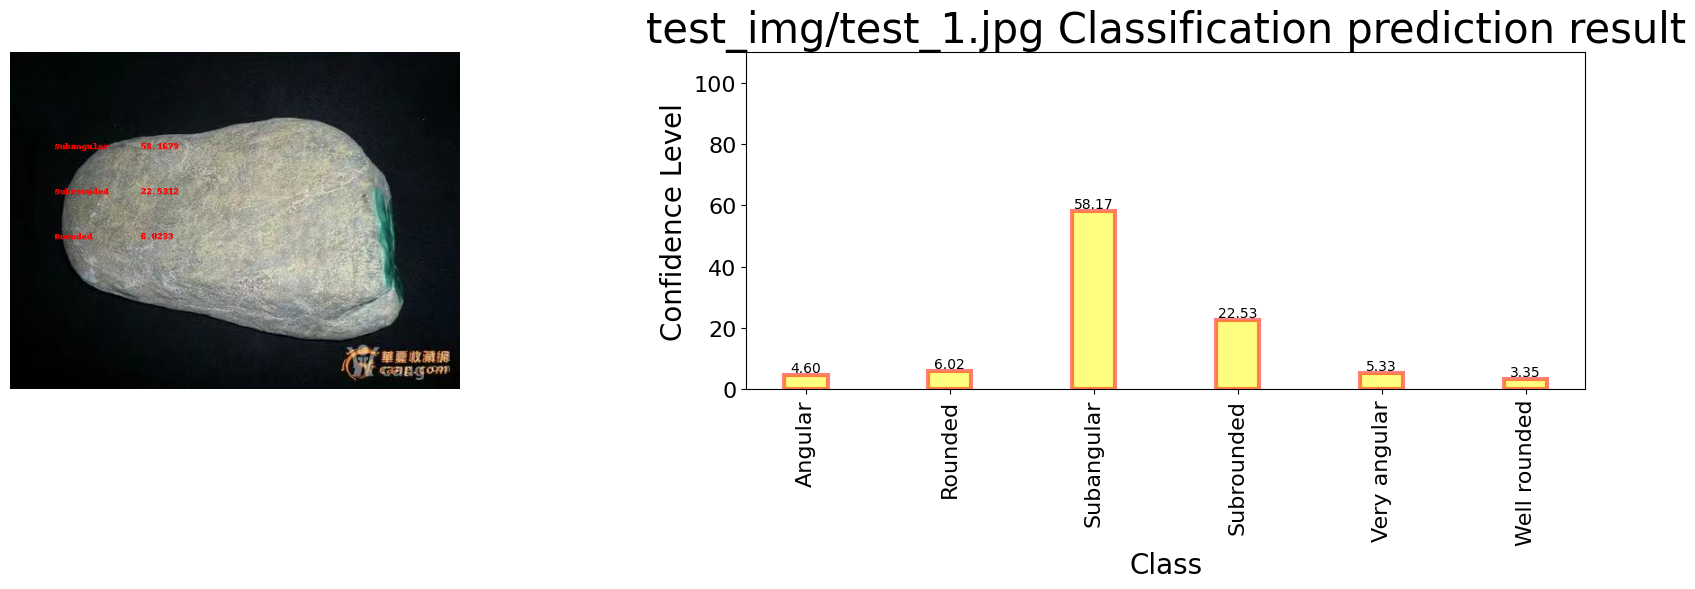

In [25]:
fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pil)
ax1.axis('off')

# 绘制右图-柱状图
ax2 = plt.subplot(1,2,2)
x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
plt.bar_label(ax, fmt='%.2f', fontsize=10) # 置信度数值

plt.title('{} Classification prediction result'.format(img_path), fontsize=30)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence Level', fontsize=20)
plt.ylim([0, 110]) # y轴取值范围
ax2.tick_params(labelsize=16) # 坐标文字大小
plt.xticks(rotation=90) # 横轴文字旋转

plt.tight_layout()
fig.savefig('output/预测图+柱状图.jpg')

### 预测结果表格输出

In [27]:
pred_df = pd.DataFrame() # 预测结果表格
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    label_idx = int(pred_ids[i]) # 获取类别号
    confidence = confs[i] * 100 # 获取置信度
    pred_df = pred_df._append({'Class':class_name, 'Class_ID':label_idx, 'Confidence(%)':confidence}, ignore_index=True) # 预测结果表格添加一行
display(pred_df) # 展示预测结果表格

,Class,Class_ID,Confidence(%)
0,Subangular,2,58.167899
1,Subrounded,3,22.531202
2,Rounded,1,6.023251
